In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

df = pd.read_csv("InvestmentReplica.csv")
df.head()

,Date,MXWO,MXWD,LEGATRUU,HFRXGL,RX1,TY1,GC1,CO1,ES1,VG1,NQ1,LLL1,TP1,DU1,TU2
0,23/10/2007,1633.44,414.14,350.214,1343.63,113.70,110.516,759.0,82.85,1525.50,4393.0,2212.00,1287.0,1570.5,103.385,103.719
1,30/10/2007,1663.89,423.26,352.541,1356.53,113.79,110.656,787.8,87.44,1536.00,4476.0,2217.75,1323.9,1610.5,103.410,103.813
2,06/11/2007,1651.59,419.51,354.176,1360.20,113.79,110.875,823.4,93.26,1525.00,4425.0,2233.50,1320.0,1575.5,103.410,104.047
3,13/11/2007,1601.81,405.98,357.222,1347.16,114.35,111.719,799.0,88.83,1483.25,4323.0,2066.75,1271.0,1440.5,103.595,104.305
4,20/11/2007,1570.74,398.54,359.445,1335.21,114.72,113.156,791.4,95.49,1446.00,4296.0,2035.50,1225.2,1472.5,103.800,104.945


In [3]:
def price2ret(x):
    return x.pct_change()

def ret2price(x):
    return (1+x).cumprod()

In [4]:
wHFRXGL = 0.5
wMXWO = 0.25
wLEGATRUU = 0.25

y = wHFRXGL*price2ret(df.HFRXGL) + wMXWO*price2ret(df.MXWO) + wLEGATRUU*price2ret(df.LEGATRUU)
target = (ret2price(y))
target = target.dropna()

In [5]:
X = df[[ "ES1", "NQ1", "TP1", "GC1", "DU1", "VG1", "TY1", "RX1"]]
X = price2ret(X)
X = X.dropna()
X = ret2price(X)

In [6]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

y_pred_Enet = []
y_test_Enet = []
weights_Enet = []

for i in range(150, len(X)):
    model = ElasticNet()
    parameters = {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
    grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X[i-150:i], target[i-150:i])
    y_pred_Enet.append(grid_search.predict(X[i:i+1]))
    y_test_Enet.append(target[i:i+1])
    weights_Enet.append(grid_search.best_estimator_.coef_)

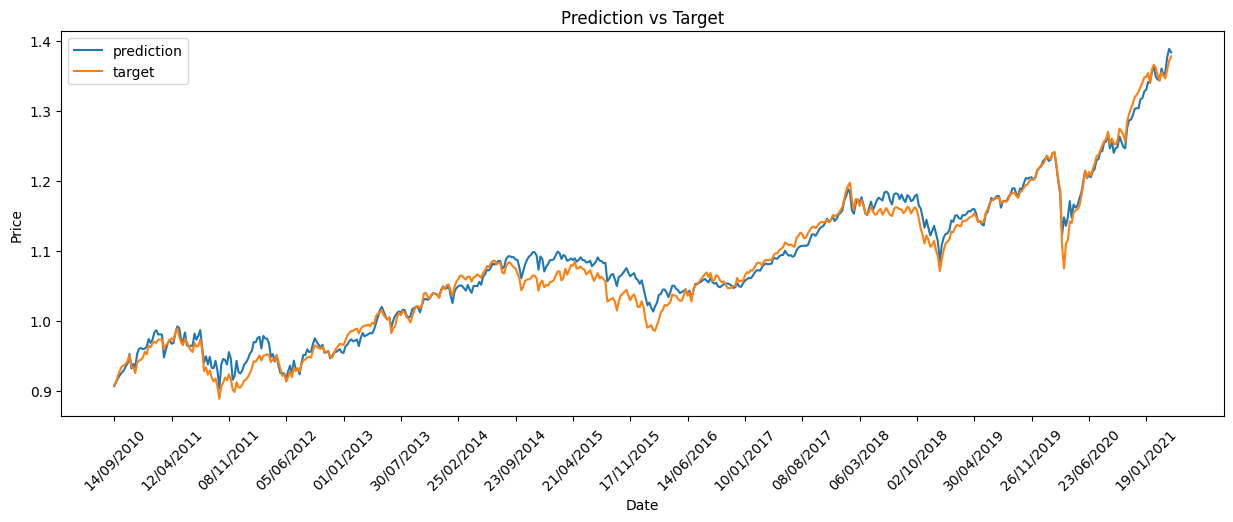

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'][len(X)-len(y_pred_Enet)+1:], y_pred_Enet, label='prediction')
plt.plot(df['Date'][len(X)-len(y_pred_Enet)+1:], y_test_Enet, label='target')
plt.title('Prediction vs Target')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(df['Date'][len(X)-len(y_pred_Enet)+1::30], rotation=45)
plt.show()

In [8]:
MSE_Enet = mean_squared_error(y_test_Enet, y_pred_Enet)
print('MSE:', MSE_Enet)

tracking_error_Enet = []
for i in range(len(y_pred_Enet)):
    tracking_error_Enet.append(y_test_Enet[i] - y_pred_Enet[i])

tracking_error_volatility_Enet = np.std(tracking_error_Enet)*np.sqrt(52)
print('Tracking Error Volatility:', tracking_error_volatility_Enet)

information_ratio_Enet = np.mean(tracking_error_Enet)/tracking_error_volatility_Enet
print('Information Ratio:', information_ratio_Enet)

turnover_Enet = []
d_weights_Enet = np.diff(weights_Enet, axis=0)
turnover_Enet = np.sum(np.abs(d_weights_Enet), axis=1) / 2

mean_annual_turnover_Enet = np.mean(turnover_Enet)*52
print('Mean Annual Turnover:', mean_annual_turnover_Enet)

tradingCosts = 0.0004
meanTradingCosts_Enet = mean_annual_turnover_Enet*tradingCosts
print('Mean Annual Trading Costs:', meanTradingCosts_Enet)

MSE: 0.00023566504919694437
Tracking Error Volatility: 0.10264704190340922
Information Ratio: -0.05599956074047027
Mean Annual Turnover: 0.3123969643683995
Mean Annual Trading Costs: 0.0001249587857473598


In [9]:
y_pred_Enet = np.array(y_pred_Enet)
np.savetxt('y_pred_Enet_Daring.csv', y_pred_Enet, delimiter=',')

In [10]:
import pickle
filename = 'y_pred_Enet_Daring.sav'
pickle.dump(y_pred_Enet, open(filename, 'wb'))